In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

In [2]:
import logging
logging.basicConfig(level=logging.WARN)

from copy import copy
import pathlib

import gym
# noinspection PyUnresolvedReferences
import gym_multiplexer

from lcs.metrics import population_metrics
from lcs.strategies.action_selection import EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.mpx import avg_experiments
from utils.plotting import COLORS

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font', **{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [3]:
from notebooks import get_from_cache_or_run

cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/2020_investigating-exploration-techniques-for-acs-in-discretized-real-valued-environments/cache/'

In [4]:
BINS = 6

experiments = 10

trials = 2*10000 # explore-exploit-explore-...

## Environment

In [5]:
class RmpxObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, bins):
        super().__init__(env)
        self._range, self._low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)
        self.bins = bins

    def observation(self, obs):
        r = (obs + np.abs(self._low)) / self._range
        b = (r * self.bins).astype(int)
        return b.astype(str).tolist()

In [6]:
rmpx_bits = 6  # [3, 6]

In [7]:
ENV_NAME = f"real-multiplexer-{rmpx_bits}bit-v0"
env = RmpxObservationWrapper(gym.make(ENV_NAME), BINS)

# visualization
env.reset()

['5', '4', '1', '5', '2', '0', '0']

In [8]:
def rmpx_metrics(agent, env):
    pop = agent.population
    metrics = {
        'reliable': len([cl for cl in pop if cl.is_reliable()])
    }
    metrics.update(population_metrics(pop, env))
    return metrics

In [9]:
base_params = {
    "classifier_length": rmpx_bits+1,
    "number_of_possible_actions": 2,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "chi": 0.0,  # do not cross-over
    "mu": 0.03,
    "u_max": 4,
    "metrics_trial_frequency": 1,
    "user_metrics_collector_fcn": rmpx_metrics
}

## Experimentation
Perform `explore-exploit` type of interaction

### Epsilon Greedy (baseline)

In [10]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy

epsilon_greedy_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-epsilon-greedy.dill',
    lambda: avg_experiments(experiments, env, trials, **epsilon_greedy_params))

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.49 ms


### Action Delay Bias

In [11]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-action-delay.dill',
    lambda: avg_experiments(experiments, env, trials, **action_delay_params))

CPU times: user 0 ns, sys: 1.64 ms, total: 1.64 ms
Wall time: 1.37 ms


### Knowledge Array Bias

In [12]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-knowledge-array.dill',
    lambda: avg_experiments(experiments, env, trials, **knowledge_array_params))

CPU times: user 1.42 ms, sys: 325 µs, total: 1.74 ms
Wall time: 1.44 ms


### Optimistic Initial Quality

In [13]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-optimistic-initial.dill',
    lambda: avg_experiments(experiments, env, trials, **op_initial_params))

CPU times: user 1.44 ms, sys: 331 µs, total: 1.77 ms
Wall time: 1.41 ms


## Visualization

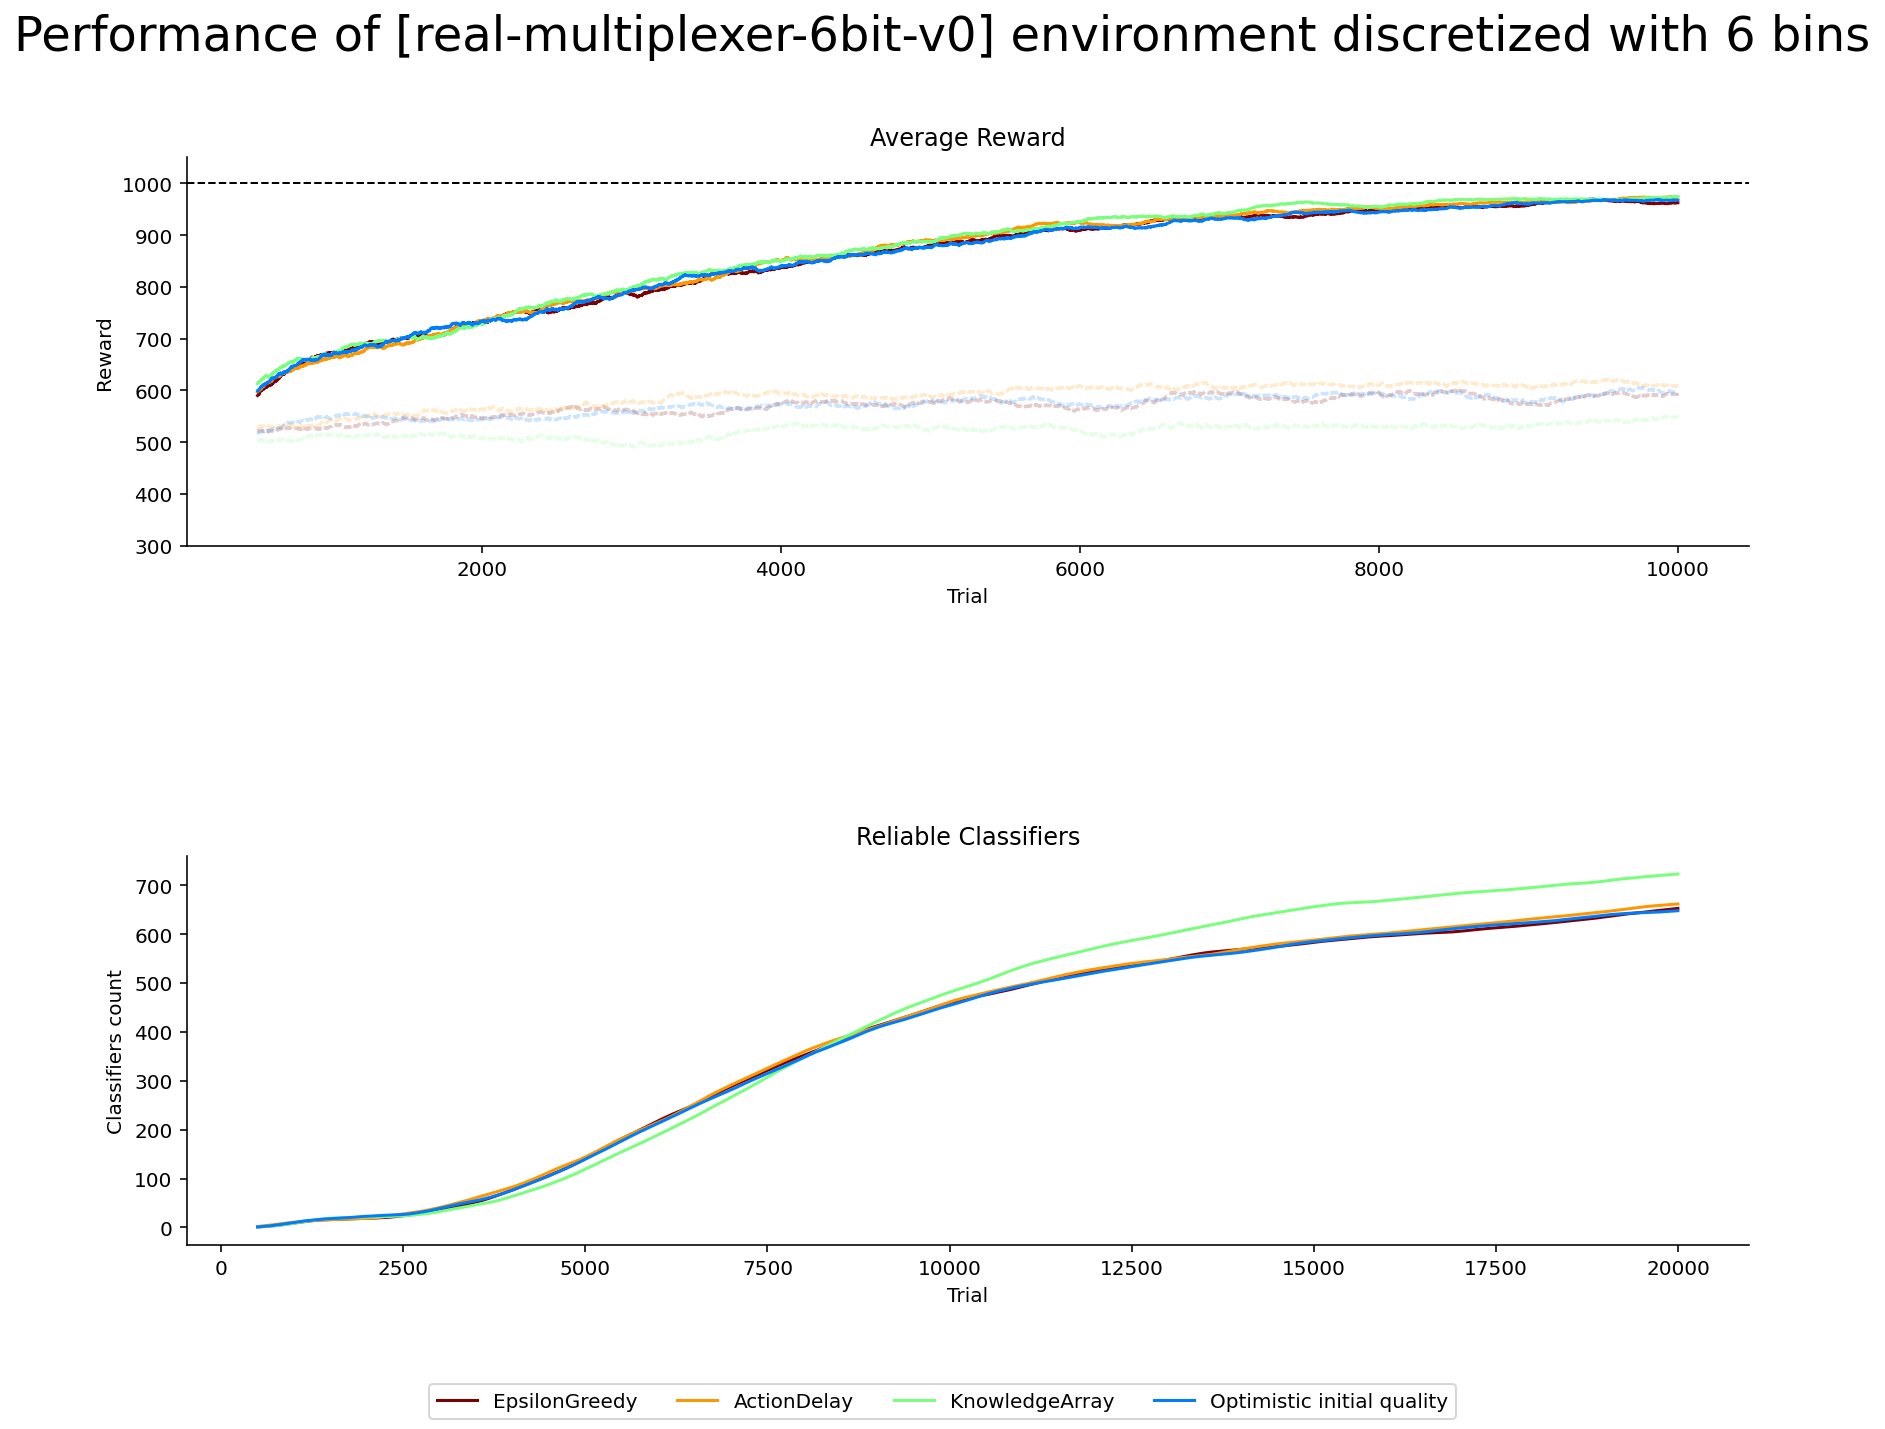

In [14]:
def plot_by_phase(df, window, label, color, ax):
    explore_df = df[df['phase'] == 'explore']
    exploit_df = df[df['phase'] == 'exploit']
    
    explore_df.reset_index(inplace=True)
    exploit_df.reset_index(inplace=True)
    
    explore_df['reward'].rolling(window=window).mean().plot(label=label, color=color, ls='--', alpha=0.2, ax=ax)
    exploit_df['reward'].rolling(window=window).mean().plot(label=label, color=color, ax=ax)


fig = plt.figure(figsize=(14, 10))

# Plots layout
gs = fig.add_gridspec(2,1, hspace=.8)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment discretized with {BINS} bins', fontsize=24)

# Each axis
ma_window = 500  # moving averge window

# Average reward
plot_by_phase(epsilon_greedy_df, ma_window, epsilon_greedy_params['action_selector'].__name__, COLORS['eg'], ax1)
plot_by_phase(action_delay_df, ma_window, action_delay_params['action_selector'].__name__, COLORS['ad'], ax1)
plot_by_phase(knowledge_array_df, ma_window, knowledge_array_params['action_selector'].__name__, COLORS['ka'], ax1)
plot_by_phase(op_initial_df, ma_window, 'Optimistic initial quality', COLORS['oiq'], ax1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Average Reward');
ax1.set_xlabel('Trial')
ax1.set_ylabel('Reward')
ax1.set_ylim(300, 1050)
ax1.axhline(y=1000, color='black', linewidth=1, linestyle="--")

# Population
epsilon_greedy_df['reliable'].rolling(window=ma_window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['reliable'].rolling(window=ma_window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['reliable'].rolling(window=ma_window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['reliable'].rolling(window=ma_window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers count')
ax2.set_title('Reliable Classifiers')
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Create legend
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
# fig.savefig('rmpx-performance.pdf')